In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

import tensorflow as tf

from google.protobuf import json_format
from tensorflow_serving.apis import prediction_log_pb2
from bulk_inferrer import executor
from tfx.proto import bulk_inferrer_pb2
from tfx.types import artifact_utils
from tfx.types import standard_artifacts

In [2]:
executor.__file__

'/home/jupyter/dataflow_example/bulk_inferrer/executor.py'

In [4]:
!pwd

/home/jupyter/dataflow_example


In [3]:
_source_data_dir = '/home/jupyter/tfx_0.23.0/tfx/tfx/components/testdata'
_output_data_dir = '/home/jupyter/dataflow_example'

In [4]:
_examples = standard_artifacts.Examples()
_examples.uri = os.path.join(_source_data_dir, 'csv_example_gen')
_examples.split_names = artifact_utils.encode_split_names(['unlabelled'])
_model = standard_artifacts.Model()
_model.uri = os.path.join(_source_data_dir, 'trainer/current')

_model_blessing = standard_artifacts.ModelBlessing()
_model_blessing.uri = os.path.join(_source_data_dir, 'model_validator/blessed')
_model_blessing.set_int_custom_property('blessed', 1)

_inference_result = standard_artifacts.InferenceResult()
_prediction_log_dir = os.path.join(_output_data_dir, 'prediction_logs')
_inference_result.uri = _prediction_log_dir

# Create context
_tmp_dir = os.path.join(_output_data_dir, '.temp')
_context = executor.Executor.Context(
    tmp_dir=_tmp_dir, unique_id='2')

In [7]:
prediction_log_pb2.PredictionLog()

In [5]:
def _get_results(prediction_log_path):
    results = []
    filepattern = os.path.join(
        prediction_log_path,
        executor._PREDICTION_LOGS_DIR_NAME) + '-?????-of-?????.gz'
    for f in tf.io.gfile.glob(filepattern):
        record_iterator = tf.compat.v1.python_io.tf_record_iterator(
            path=f,
            options=tf.compat.v1.python_io.TFRecordOptions(
                tf.compat.v1.python_io.TFRecordCompressionType.GZIP))
        for record_string in record_iterator:
            prediction_log = prediction_log_pb2.PredictionLog()
            prediction_log.MergeFromString(record_string)
            results.append(prediction_log)
    return results

In [6]:
input_dict = {
    'examples': [_examples],
    'model': [_model],
    'model_blessing': [_model_blessing],
}
output_dict = {
    'inference_result': [_inference_result],
}
# Create exe properties.
exec_properties = {
    'data_spec':
        json_format.MessageToJson(
            bulk_inferrer_pb2.DataSpec(), preserving_proto_field_name=True),
    'model_spec':
        json_format.MessageToJson(
            bulk_inferrer_pb2.ModelSpec(),
            preserving_proto_field_name=True),
    'component_id':
        'test_component' #self.component_id,
}

# Run executor.
bulk_inferrer = executor.Executor(_context)
bulk_inferrer.Do(input_dict, output_dict, exec_properties)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
INFO:tensorflow:Restoring parameters from /home/jupyter/tfx_0.23.0/tfx/tfx/components/testdata/trainer/current/serving_model_dir/export/chicago-taxi/1584391735/variables/variables


In [11]:
result[0]

tensorflow_serving.apis.prediction_log_pb2.PredictionLog

In [13]:
result = _get_results(_prediction_log_dir)
json_format.MessageToJson(result[0])

str

In [16]:
json_format.MessageToDict(result[0])

{'classifyLog': {'request': {'input': {'exampleList': {'examples': [{'features': {'feature': {'trip_start_hour': {'int64List': {'value': ['15']}},
         'payment_type': {'bytesList': {'value': ['Q2FzaA==']}},
         'dropoff_community_area': {'int64List': {'value': ['6']}},
         'dropoff_latitude': {'floatList': {'value': [41.944225]}},
         'trip_seconds': {'int64List': {'value': ['660']}},
         'trip_start_month': {'int64List': {'value': ['3']}},
         'trip_start_day': {'int64List': {'value': ['3']}},
         'pickup_census_tract': {},
         'company': {'bytesList': {'value': ['VGF4aSBBZmZpbGlhdGlvbiBTZXJ2aWNlcw==']}},
         'trip_miles': {'floatList': {'value': [0.1]}},
         'pickup_community_area': {'int64List': {'value': ['6']}},
         'dropoff_census_tract': {},
         'dropoff_longitude': {'floatList': {'value': [-87.656]}},
         'fare': {'floatList': {'value': [8.45]}},
         'trip_start_timestamp': {'int64List': {'value': ['136310220

In [ ]:
{
        "namespace": "example.avro",
        "type": "record",
        "name": "User",
        "fields": [
          {"name": "name",
           "type": "string"},
          {"name": "favorite_number",
           "type": ["int", "null"]},
          {"name": "favorite_color",
           "type": ["string", "null"]}
        ]
      }

In [15]:
type(json_format.MessageToDict(result[0]))

dict

In [20]:
result[0].classify_log.response

result {
  classifications {
    classes {
      label: "0"
      score: 0.9002926349639893
    }
    classes {
      label: "1"
      score: 0.09970736503601074
    }
  }
}

In [7]:
table_spec = 'res-nbcupea-dev-ds-sandbox-001:oneapp.test_bigquery_beam'

In [8]:
table_schema = 'source:STRING, quote:STRING'

In [14]:
import apache_beam as beam

with beam.Pipeline() as p:
    quotes = p | beam.Create([
        {
            'source': 'Mahatma Gandhi', 'quote': 'My life is my message.'
        },
        {
            'source': 'Yoda', 'quote': "Do, or do not. There is no 'try'."
        },
    ])
    quotes | beam.io.WriteToBigQuery(
    table_spec,
    schema=table_schema,
    write_disposition=beam.io.BigQueryDisposition.WRITE_TRUNCATE,
    create_disposition=beam.io.BigQueryDisposition.CREATE_IF_NEEDED,
    custom_gcs_temp_location='gs://benk-dev-sandbox/temp'
    )

##### Copyright &copy; 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://urldefense.com/v3/__https://www.apache.org/licenses/LICENSE-2.0*5Cn__;JQ!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4Rxhel3RfE$ #
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TFX – Developing With Apache Beam

[Apache Beam](https://urldefense.com/v3/__https://www.tensorflow.org/tfx/guide/beam__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxlMaOx6c$ ) is an open source, unified model for defining both batch and streaming data-parallel processing pipelines. TFX uses Apache Beam to implement data-parallel pipelines. The pipeline is then executed by one of Beam's supported distributed processing back-ends or "runners", which include [Dataflow](https://urldefense.com/v3/__https://cloud.google.com/dataflow__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4Rx_xDiz6Q$ ), [Apache Flink](https://urldefense.com/v3/__https://flink.apache.org/__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxUIpCch4$ ), [Apache Spark](https://urldefense.com/v3/__https://spark.apache.org/__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxVA2PkcU$ ), [Apache Samza](https://urldefense.com/v3/__http://samza.apache.org/__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4Rx5goppac$ ), and others.

TFX is designed to be scalable to very large datasets which require substantial resources.  Distributed pipeline frameworks such as Apache Beam offer the ability to distribute processing across compute clusters and apply the resources required.  Many of the standard TFX components use Apache Beam, and custom components that you may write may also benefit from using Apache Beam for distibuted processing.

This notebook introduces the concepts and code patterns for developing with the Apache Beam Python API. This is especially important for developers who will be creating custom TFX components which may require substantial computing resources, and will benefit from distributed processing using beam.

### [DirectRunner](https://beam.apache.org/documentation/runners/direct/)

In this notebook, to avoid the requirement for a distributed processing cluster we will instead use Beam's [`DirectRunner`](https://urldefense.com/v3/__https://beam.apache.org/documentation/runners/direct/__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxE4HG0-g$ ).  The `DirectRunner` is also very convenient when developing Beam pipelines. The `DirectRunner` executes pipelines on your machine and is designed to validate that pipelines adhere to the Beam programming model as closely as possible. Instead of focusing on efficient pipeline execution, the `DirectRunner` performs additional checks to ensure that users do not rely on semantics that are not guaranteed by the model.

## Setup
First, we install the necessary packages, download data, import modules and set up paths.

### Install Apache Beam

In [ ]:
!pip install -q -U \
  apache-beam \
  apache-beam[interactive]

### Import packages
We import necessary packages, including Beam.

In [2]:
!pip install -q -U graphviz

In [3]:
import apache_beam as beam
from apache_beam import pvalue
from apache_beam.runners.interactive.display import pipeline_graph
import graphviz

Check the version.

In [4]:
print('Beam version: {}'.format(beam.__version__))

Beam version: 2.23.0


## Beam Python Syntax

Beam uses a [special Python syntax](https://urldefense.com/v3/__https://beam.apache.org/documentation/programming-guide/*applying-transforms__;Iw!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4Rxw19zxq8$ ) to define and invoke transforms.  For example, in this line:

>`result = pass_this | 'name this step' >> to_this_call`

The method `to_this_call` is being invoked and passed the object called `pass_this`, and this operation will be referred to as [name this step](https://urldefense.com/v3/__https://stackoverflow.com/questions/50519662/what-does-the-redirection-mean-in-apache-beam-python__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxMFC5UkE$ ) in a stack trace or pipeline diagram.  The result of the call to `to_this_call` is returned in `result`.  You will often see stages of a pipeline chained together like this:

>`result = apache_beam.Pipeline() | 'first step' >> do_this_first() | 'second step' >> do_this_last()`

and since that started with a new pipeline, you can continue like this:

>`next_result = result | 'doing more stuff' >> another_function()`

## Create a Beam Pipeline

Create a pipeline, including a simple [`PCollection`](https://urldefense.com/v3/__https://beam.apache.org/releases/javadoc/2.1.0/org/apache/beam/sdk/values/PCollection.html__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4Rxgmi9VMc$ ) and a [`ParDo()`](https://urldefense.com/v3/__https://beam.apache.org/releases/javadoc/2.0.0/org/apache/beam/sdk/transforms/ParDo.html__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxfbsGH5U$ ) transform.

* A `PCollection<T>` is an **immutable collection** of values of type `T`. A `PCollection` can contain either a bounded or unbounded number of elements. Bounded and unbounded `PCollections` are produced as the output of `PTransforms` (including root `PTransforms` like `Read` and `Create`), and can be passed as the inputs of other `PTransforms`.
* `ParDo` is the core **element-wise** transform in Apache Beam, invoking a user-specified function on each of the elements of the input `PCollection` to produce zero or more output elements, all of which are collected into the output `PCollection`.

This can be done in different ways, depending on coding style preferences. First, use the `.run()` method.

In [5]:
first_pipeline = beam.Pipeline()

lines = (first_pipeline
         | "Create" >> beam.Create(["Hello", "World", "!!!"]) # PCollection
         | "Print" >> beam.ParDo(print)) # ParDo transform

result = first_pipeline.run()
result.state

Hello
World
!!!


'DONE'

Display the structure of this pipeline.

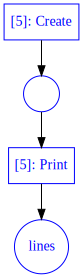

In [6]:
def display_pipeline(pipeline):
  graph = pipeline_graph.PipelineGraph(pipeline)
  return graphviz.Source(graph.get_dot())

display_pipeline(first_pipeline)

Using a different coding style, invoke run inside a `with` block.

Hello
World
!!!


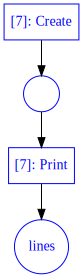

In [7]:
with beam.Pipeline() as with_pipeline:
  lines = (with_pipeline
         | "Create" >> beam.Create(["Hello", "World", "!!!"])
         | "Print" >> beam.ParDo(print))

display_pipeline(with_pipeline)

Notice that both pipelines and their outputs are the same.

### Now You Try

This is a good point to stop reading and try writing code yourself, as a way to help you learn.

**Exercise 1 — Creating and Running Your Beam Pipeline**

1. Build a Beam pipeline that creates a PCollection containing integers 0 to 10 and prints them.
2. Add a step in the pipeline to square each item.
3. Display the pipeline.

*Warning*: the `ParDo()` method must either return `None` or a list.

![Solution](https://urldefense.com/v3/__https://www.tensorflow.org/site-assets/images/marketing/learn/tfx-hero.svg__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxzvhZF7w$ )

**Solution**:

In [5]:
def passthrough(label, x): # Utility for printing and returning the element
  print(label, x)
  return x

# This includes printing stages for illustration.
with beam.Pipeline() as with_pipeline:
  lines = (with_pipeline
         | "Create" >> beam.Create(range(10 + 1))
         | 'Print0' >> beam.Map(lambda x: passthrough('x =', x))
         | "Square" >> beam.ParDo(lambda x: [x ** 2])
         | "Print1" >> beam.Map(lambda x: passthrough('x^2 =', x)))

display_pipeline(with_pipeline)

x = 0
x^2 = 0
x = 1
x^2 = 1
x = 2
x^2 = 4
x = 3
x^2 = 9
x = 4
x^2 = 16
x = 5
x^2 = 25
x = 6
x^2 = 36
x = 7
x^2 = 49
x = 8
x^2 = 64
x = 9
x^2 = 81
x = 10
x^2 = 100


NameError: name 'display_pipeline' is not defined

# Core Transforms
---
Beam has a set of core transforms on data that is contained in `PCollections`.  In the cells that follow, explore several core transforms and observe the results in order to develop some understanding and intuition for what each transform does.

## [Map](https://beam.apache.org/documentation/transforms/python/elementwise/map/)
The `Map` transform applies a simple 1-to-1 mapping function over each element in the collection.  `Map` accepts a function that returns a single element for every input element in the `PCollection`.  You can pass functions with multiple arguments to `Map`. They are passed as additional positional arguments or keyword arguments to the function.

First, compare the results of a `ParDo` transform and a `Map` transform for a multiply operation.

In [9]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | "Create" >> beam.Create([1, 2, 3])
           | 'Print0' >> beam.Map(lambda x: passthrough('x =', x))
           | "Multiply" >> beam.ParDo(lambda number: [number * 2]) # ParDo with integers
           | 'Print1' >> beam.Map(lambda x: passthrough('x * 2 =', x)))

x = 1
x * 2 = 2
x = 2
x * 2 = 4
x = 3
x * 2 = 6


In [10]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
         | "Create" >> beam.Create([1, 2, 3])
         | 'Print0' >> beam.Map(lambda x: passthrough('x =', x))
         | "Multiply" >> beam.Map(lambda number: number * 2) # Map with integers
         | 'Print1' >> beam.Map(lambda x: passthrough('x * 2 =', x)))

x = 1
x * 2 = 2
x = 2
x * 2 = 4
x = 3
x * 2 = 6


Notice that the results are the same.  Now try it with a split operation.

In [11]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
         | "Create" >> beam.Create(["Hello Beam", "This is cool"])
         | 'Print0' >> beam.Map(lambda x: passthrough('Sentence:', x))
         | "Split" >> beam.ParDo(lambda sentence: sentence.split()) # ParDo with strings
         | 'Print1' >> beam.Map(lambda x: passthrough('Word:', x)))

Sentence: Hello Beam
Word: Hello
Word: Beam
Sentence: This is cool
Word: This
Word: is
Word: cool


In [12]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
         | "Create" >> beam.Create(["Hello Beam", "This is cool"])
         | 'Print0' >> beam.Map(lambda x: passthrough('Sentence:', x))
         | "Split" >> beam.Map(lambda sentence: sentence.split()) # Map with strings
         | 'Print1' >> beam.Map(lambda x: passthrough('Words:', x)))

Sentence: Hello Beam
Words: ['Hello', 'Beam']
Sentence: This is cool
Words: ['This', 'is', 'cool']


Notice that `ParDo` returned individual elements, while `Map` returned lists.

## DoFn and [FlatMap](https://beam.apache.org/documentation/transforms/python/elementwise/flatmap/)
Now try working with a `DoFn` in a `ParDo`, and compare that to using `FlatMap`.

In [2]:
import apache_beam as beam

In [4]:
class BreakIntoWordsDoFn(beam.DoFn):
    def process(self, element):
      return element.split()

with beam.Pipeline() as pipeline:
  lines = (pipeline
         | "Create" >> beam.Create(["Hello Beam", "This is cool"])
         | 'Print0' >> beam.Map(lambda x: passthrough('Sentence:', x))
         | "Split" >> beam.ParDo(BreakIntoWordsDoFn()) # Apply a DoFn with a process method
         | 'Print1' >> beam.Map(lambda x: passthrough('Word:', x)))

NameError: name 'passthrough' is not defined [while running '[4]: Print0']

In [14]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
         | "Create" >> beam.Create(["Hello Beam", "This is cool"])
         | 'Print0' >> beam.Map(lambda x: passthrough('Sentence:', x))
         | "Split" >> beam.FlatMap(lambda sentence: sentence.split()) # Compare to a FlatMap
         | 'Print1' >> beam.Map(lambda x: passthrough('Word:', x)))

Sentence: Hello Beam
Word: Hello
Word: Beam
Sentence: This is cool
Word: This
Word: is
Word: cool


Again, notice that the results are the same. There is often more than one way to generate the same result!

## [GroupByKey](https://beam.apache.org/documentation/transforms/python/aggregation/groupbykey/)
`GroupByKey` takes a keyed collection of elements and produces a collection where each element consists of a key and all values associated with that key.

`GroupByKey` is a transform for processing collections of key/value pairs. It’s a parallel reduction operation, analogous to the Shuffle phase of a Map/Shuffle/Reduce-style algorithm. The input to `GroupByKey` is a collection of key/value pairs that represents a multimap, where the collection contains multiple pairs that have the same key, but different values. Given such a collection, you use `GroupByKey` to collect all of the values associated with each unique key.

`GroupByKey` is a good way to aggregate data that has something in common. For example, if you have a collection that stores records of customer orders, you might want to group together all the orders from the same postal code (wherein the “key” of the key/value pair is the postal code field, and the “value” is the remainder of the record).

In [15]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(['apple', 'ball', 'car', 'bear', 'cheetah', 'ant'])
           | 'Words' >> beam.Map(lambda x: passthrough('Word:', x))
           | beam.Map(lambda word: (word[0], word))
           | 'Keyed' >> beam.Map(lambda x: passthrough('Keyed Tuple:', x))
           | beam.GroupByKey()
           | 'Groups' >> beam.Map(lambda x: passthrough('Grouped:', x)))

Word: apple
Keyed Tuple: ('a', 'apple')
Word: ball
Keyed Tuple: ('b', 'ball')
Word: car
Keyed Tuple: ('c', 'car')
Word: bear
Keyed Tuple: ('b', 'bear')
Word: cheetah
Keyed Tuple: ('c', 'cheetah')
Word: ant
Keyed Tuple: ('a', 'ant')
Grouped: ('a', ['apple', 'ant'])
Grouped: ('b', ['ball', 'bear'])
Grouped: ('c', ['car', 'cheetah'])


### Now You Try

This is a good point to stop reading and try writing code yourself, as a way to help you learn.

**Exercise 2 — Group Items by Key**

1. Build a Beam pipeline that creates a PCollection containing integers 0 to 10 and prints them.
2. Add a step in the pipeline to add a key to each item that will indicate whether it is even or odd.
3. Use `GroupByKey` to group even items together and odd items together.

In [45]:
def passthrough(label, value):
    print(label, value)
    return value

with beam.Pipeline() as pipeline:
    lines = (pipeline
             | beam.Create(range(11))
             | beam.Map(lambda x: passthrough('num', x))
             | beam.Map(lambda x: (x%2, x))
             | beam.GroupByKey()
             | beam.Map(lambda x: passthrough('grouped', x))
            )

num 0
num 1
num 2
num 3
num 4
num 5
num 6
num 7
num 8
num 9
num 10
grouped (0, [0, 2, 4, 6, 8, 10])
grouped (1, [1, 3, 5, 7, 9])


![Solution](https://urldefense.com/v3/__https://www.tensorflow.org/site-assets/images/marketing/learn/tfx-hero.svg__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxzvhZF7w$ )

**Solution**:

In [ ]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(10 + 1))
           | 'Number' >> beam.Map(lambda x: passthrough('Number:', x))
           | beam.Map(lambda x: ("odd" if x % 2 else "even", x))
           | 'Even/Odd' >> beam.Map(lambda x: passthrough('Even/Odd:', x))
           | beam.GroupByKey()
           | 'Groups' >> beam.Map(lambda x: passthrough('Group:', x)))

`CoGroupByKey` can combine multiple `PCollections`, assuming every element is a tuple whose first item is the key to join on.

In [23]:
pipeline = beam.Pipeline()

# Create two PCollections
fruits = pipeline | 'Fruits' >> beam.Create(['apple',
                                             'banana',
                                             'cherry'])
print('fruits is a {}'.format(type(fruits)))

countries = pipeline | 'Countries' >> beam.Create(['australia',
                                                   'brazil',
                                                   'belgium',
                                                   'canada'])
print('countries is a {}'.format(type(countries)))

def add_key(word):
    return (word[0], word)

# Create PCollections of keyed tuples
fruits_with_keys = (fruits | "fruits_with_keys" >> beam.Map(add_key)
                          | 'Fruit' >> beam.Map(lambda x: passthrough('Fruit:', x)))
countries_with_keys = (countries | "countries_with_keys" >> beam.Map(add_key)
                          | 'Country' >> beam.Map(lambda x: passthrough('Country:', x)))
fruitcountries = {"fruits": fruits_with_keys, "countries": countries_with_keys}

# Print the PCollections
print('fruits_with_keys is a {}'.format(type(fruits_with_keys)))
_ = (fruits_with_keys | 'Print0' >> beam.combiners.ToList()
  | beam.Map(lambda x: print('fruits_with_keys:', x)))

print('countries_with_keys is a {}'.format(type(countries_with_keys)))
_ = (countries_with_keys | 'Print1' >> beam.combiners.ToList()
  | beam.Map(lambda x: print('countries_with_keys:', x)))

print('fruitcountries: {}'.format(fruitcountries))

(fruitcountries | beam.CoGroupByKey() | beam.Map(lambda x: print('CoGrouped:', x)))

print('\nRun the pipeline')
pipeline.run().state # Try commenting out this line

fruits is a <class 'apache_beam.pvalue.PCollection'>
countries is a <class 'apache_beam.pvalue.PCollection'>
fruits_with_keys is a <class 'apache_beam.pvalue.PCollection'>
countries_with_keys is a <class 'apache_beam.pvalue.PCollection'>
fruitcountries: {'fruits': <PCollection[[23]: Fruit.None] at 0x7f4a2aa1e690>, 'countries': <PCollection[[23]: Country.None] at 0x7f4a2a9d9dd0>}

Run the pipeline
Fruit:: ('a', 'apple')
Fruit:: ('b', 'banana')
Fruit:: ('c', 'cherry')
Country:: ('a', 'australia')
Country:: ('b', 'brazil')
Country:: ('b', 'belgium')
Country:: ('c', 'canada')
CoGrouped: ('a', {'fruits': ['apple'], 'countries': ['australia']})
CoGrouped: ('b', {'fruits': ['banana'], 'countries': ['brazil', 'belgium']})
CoGrouped: ('c', {'fruits': ['cherry'], 'countries': ['canada']})
fruits_with_keys: [('a', 'apple'), ('b', 'banana'), ('c', 'cherry')]
countries_with_keys: [('a', 'australia'), ('b', 'brazil'), ('b', 'belgium'), ('c', 'canada')]


'DONE'

Try commenting out the last line, and notice that while a `PCollection` is created for the `CoGroupByKey` operation, the pipeline is not actually executed.

Also try running the cell above a few times, and note how the order of the print statements changes.

## [Combine](https://beam.apache.org/documentation/programming-guide/#combine)
`Combine` is a transform for combining collections of elements or values. `Combine` has variants that work on entire `PCollections`, and some that combine the values for each key in `PCollections` of key/value pairs.

To apply a `Combine` transform, you must provide the function that contains the logic for combining the elements or values. The combining function should be **commutative and associative**, as the function is not necessarily invoked exactly once on all values with a given key. Because the input data (including the value collection) **may be distributed across multiple workers**, the combining function might be called multiple times to perform partial combining on subsets of the value collection. The Beam SDK also provides some pre-built combine functions for common numeric combination operations such as `sum`, `min`, and `max`.

Simple combine operations, such as sums, can usually be implemented as a simple function. More complex combination operations might require you to create a subclass of `CombineFn` that has an accumulation type distinct from the input/output type.

Try it first with a sum.

In [24]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create([1, 2, 3, 4, 5])
           | 'Numbers' >> beam.Map(lambda x: passthrough('Number:', x))
           | beam.CombineGlobally(sum)
           | 'Sums' >> beam.Map(lambda x: passthrough('Sum:', x)))

Number:: 1
Number:: 2
Number:: 3
Number:: 4
Number:: 5
Sum:: 15


Now try calculating the mean using the pre-built combine function.

In [25]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create([1, 2, 3, 4, 5])
           | 'Numbers' >> beam.Map(lambda x: passthrough('Number:', x))
           | beam.combiners.Mean.Globally()
           | 'Means' >> beam.Map(lambda x: passthrough('Mean:', x)))

Number:: 1
Number:: 2
Number:: 3
Number:: 4
Number:: 5
Mean:: 3.0


Now try creating a custom `CombineFn` to calculate the mean. Note the required concrete implementations.

In [26]:
class AverageFn(beam.CombineFn):
  def create_accumulator(self):
    return (0.0, 0)
  
  def add_input(self, accumulator, input_):
    total, count = accumulator
    total += input_
    count += 1
    return (total, count)

  def merge_accumulators(self, accumulators):
    totals, counts = zip(*accumulators)
    return sum(totals), sum(counts)

  def extract_output(self, accumulator):
    total, count = accumulator
    return total / count if count else float("NaN")

with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create([1, 2, 3, 4, 5])
           | 'Numbers' >> beam.Map(lambda x: passthrough('Number:', x))
           | beam.CombineGlobally(AverageFn())
           | 'Means' >> beam.Map(lambda x: passthrough('Mean:', x)))

Number:: 1
Number:: 2
Number:: 3
Number:: 4
Number:: 5
Mean:: 3.0


Now try a simple `Count` using the pre-built combine function. This one does a `PerElement` count.

In [27]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(['bob', 'alice', 'alice', 'bob', 'charlie', 'alice'])
           | 'Persons' >> beam.Map(lambda x: passthrough('Person:', x))
           | beam.combiners.Count.PerElement()
           | 'Counts' >> beam.Map(lambda x: passthrough('Count:', x)))

Person:: bob
Person:: alice
Person:: alice
Person:: bob
Person:: charlie
Person:: alice
Count:: ('bob', 2)
Count:: ('alice', 3)
Count:: ('charlie', 1)


We can also create a count by using `CombinePerKey` with the Python `sum` function, using the people as keys.

In [28]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(['bob', 'alice', 'alice', 'bob', 'charlie', 'alice'])
           | 'Persons' >> beam.Map(lambda x: passthrough('Person:', x))
           | beam.Map(lambda word: (word, 1))
           | 'Keyed' >> beam.Map(lambda x: passthrough('Key:', x))
           | beam.CombinePerKey(sum)
           | 'Counts' >> beam.Map(lambda x: passthrough('Count:', x)))

Person:: bob
Key:: ('bob', 1)
Person:: alice
Key:: ('alice', 1)
Person:: alice
Key:: ('alice', 1)
Person:: bob
Key:: ('bob', 1)
Person:: charlie
Key:: ('charlie', 1)
Person:: alice
Key:: ('alice', 1)
Count:: ('bob', 2)
Count:: ('alice', 3)
Count:: ('charlie', 1)


Now try a simple `Count` using the pre-built combine function. This one does a count `Globally`.

In [29]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(['bob', 'alice', 'alice', 'bob', 'charlie', 'alice'])
           | 'Persons' >> beam.Map(lambda x: passthrough('Person:', x))
           | beam.combiners.Count.Globally()
           | 'Counts' >> beam.Map(lambda x: passthrough('Count:', x)))

Person:: bob
Person:: alice
Person:: alice
Person:: bob
Person:: charlie
Person:: alice
Count:: 6


### Now You Try

This is a good point to stop reading and try writing code yourself, as a way to help you learn.

**Exercise 3 — Combine Items**

1. Start with Beam pipeline you built in the previous exercise: it creates a `PCollection` containing integers 0 to 10, and labels them as odd or even.
2. Add another step to make the pipeline compute the square of each number.
3. Add a step that groups all of the odd or even numbers and computes the mean of each group (i.e., the mean of all odd numbers between 0 and 10, and the mean of all even numbers between 0 and 10). You can use the `AverageFn` that we created above.

Avg: (0, 36.666666666666664)
Avg: (1, 33.0)


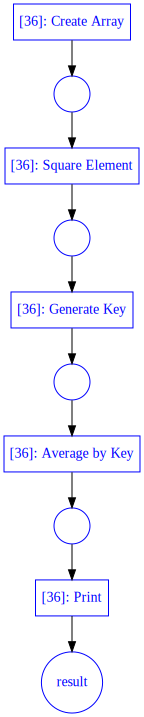

In [36]:
with beam.Pipeline() as pipeline:
    result = (
        pipeline
        | 'Create Array' >> beam.Create(range(11))
        | 'Square Element' >> beam.Map(lambda x: x**2)
        | 'Generate Key' >> beam.Map(lambda x: (x%2, x))
        | 'Average by Key' >> beam.CombinePerKey(AverageFn())
        | 'Print' >> beam.Map(lambda x: passthrough('Avg', x))
    )
# 0 2 4 6 8 10
# 1 3 5 7 9
display_pipeline(pipeline)

![Solution](https://urldefense.com/v3/__https://www.tensorflow.org/site-assets/images/marketing/learn/tfx-hero.svg__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxzvhZF7w$ )

**Solution**:

Number:: 0
OddEven:: ('even', 0)
Squared:: ('even', 0)
Number:: 1
OddEven:: ('odd', 1)
Squared:: ('odd', 1)
Number:: 2
OddEven:: ('even', 2)
Squared:: ('even', 4)
Number:: 3
OddEven:: ('odd', 3)
Squared:: ('odd', 9)
Number:: 4
OddEven:: ('even', 4)
Squared:: ('even', 16)
Number:: 5
OddEven:: ('odd', 5)
Squared:: ('odd', 25)
Number:: 6
OddEven:: ('even', 6)
Squared:: ('even', 36)
Number:: 7
OddEven:: ('odd', 7)
Squared:: ('odd', 49)
Number:: 8
OddEven:: ('even', 8)
Squared:: ('even', 64)
Number:: 9
OddEven:: ('odd', 9)
Squared:: ('odd', 81)
Number:: 10
OddEven:: ('even', 10)
Squared:: ('even', 100)
Mean:: ('even', 36.666666666666664)
Mean:: ('odd', 33.0)


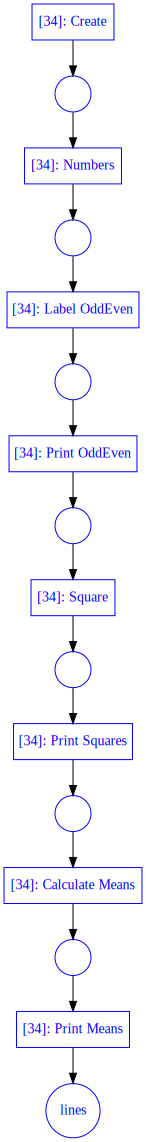

In [34]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(10 + 1))
           | 'Numbers' >> beam.Map(lambda x: passthrough('Number:', x))
           | 'Label OddEven' >> beam.Map(lambda x: ("odd" if x % 2 else "even", x))
           | 'Print OddEven' >> beam.Map(lambda x: passthrough('OddEven:', x))
           | 'Square' >> beam.Map(lambda x: (x[0], x[1] ** 2))
           | 'Print Squares' >> beam.Map(lambda x: passthrough('Squared:', x))
           | 'Calculate Means' >> beam.CombinePerKey(AverageFn())
           | 'Print Means' >> beam.Map(lambda x: passthrough('Mean:', x)))

display_pipeline(pipeline)

## [Flatten](https://beam.apache.org/documentation/programming-guide/#flatten)
`Flatten` is a transform for `PCollection` objects that store **the same data type**. `Flatten` merges multiple `PCollection` objects into a single logical `PCollection`.

#### Data encoding in merged collections
By default, the coder for the output `PCollection` is the same as the coder for the first `PCollection` in the input `PCollectionList`. However, the input `PCollection` objects can each use different coders, **as long as they all contain the same data type** in your chosen language.

#### Merging windowed collections
When using `Flatten` to merge `PCollection` objects that have a windowing strategy applied, all of the `PCollection` objects you want to merge must use a compatible windowing strategy and window sizing. For example, all the collections you're merging must all use (hypothetically) identical 5-minute fixed windows or 4-minute sliding windows starting every 30 seconds.

If your pipeline attempts to use `Flatten` to merge `PCollection` objects with incompatible windows, Beam generates an `IllegalStateException` error when your pipeline is constructed.

result:: ['ball', 'book', 'bow', 'apple', 'ant', 'arrow']
wordsStartingWithA:: ['apple', 'ant', 'arrow']
wordsStartingWithB:: ['ball', 'book', 'bow']


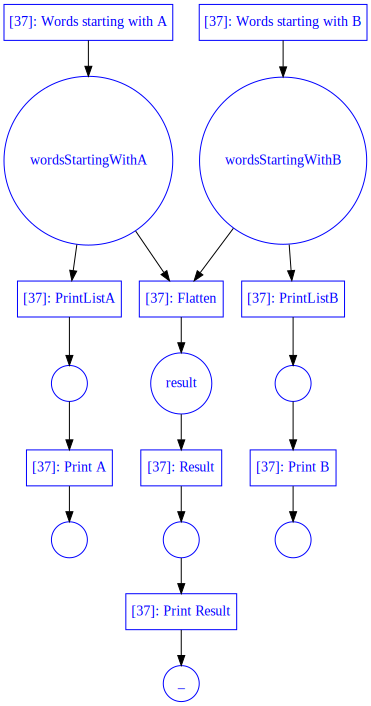

In [37]:
pipeline = beam.Pipeline()

wordsStartingWithA = pipeline | 'Words starting with A' >> beam.Create(['apple', 'ant', 'arrow'])

# Note the required parens for multi-line
wordsStartingWithB = (pipeline
  | 'Words starting with B' >> beam.Create(['ball', 'book', 'bow']))

result = (wordsStartingWithA, wordsStartingWithB) | beam.Flatten()

# Print the PCollections
_ = (wordsStartingWithA | 'PrintListA' >> beam.combiners.ToList()
  | 'Print A' >> beam.Map(lambda x: passthrough('wordsStartingWithA:', x)))
_ = (wordsStartingWithB | 'PrintListB' >> beam.combiners.ToList()
  | 'Print B' >> beam.Map(lambda x: passthrough('wordsStartingWithB:', x)))
_ = (result | 'Result' >> beam.combiners.ToList()
  | 'Print Result' >> beam.Map(lambda x: passthrough('result:', x)))

pipeline.run().state
display_pipeline(pipeline)

Try running the cell above a few times, and note how the order of the print statements changes.

## [Partition](https://beam.apache.org/documentation/programming-guide/#partition)
`Partition` is a transform for `PCollection` objects that store **the same data type**. `Partition` splits a single `PCollection` into a fixed number of smaller collections.

`Partition` divides the elements of a `PCollection` according to a **partitioning function** that you provide. The partitioning function contains the logic that determines how to split up the elements of the input `PCollection` into each resulting partition `PCollection`. The number of partitions must be determined at graph construction time. You can, for example, pass the number of partitions as a command-line option at runtime (which will then be used to build your pipeline graph), but you cannot determine the number of partitions in mid-pipeline (based on data calculated after your pipeline graph is constructed, for instance).

Let's partition a group of numbers in ranges of 100.

Medium:: [110, 100, 150]
Large:: [350]
Small:: [1, 2, 4, 5, 3]


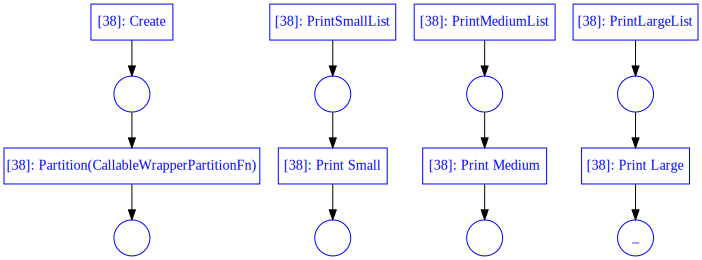

In [38]:
def partition_fn(number, num_partitions):
    partition = number // 100
    return min(partition, num_partitions - 1)

with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create([1, 110, 2, 350, 4, 5, 100, 150, 3])
           | beam.Partition(partition_fn, 3))
  
  # Print the PCollections
  _ = (lines[0] | 'PrintSmallList' >> beam.combiners.ToList()
    | 'Print Small' >> beam.Map(lambda x: passthrough('Small:', x)))
  _ = (lines[1] | 'PrintMediumList' >> beam.combiners.ToList()
    | 'Print Medium' >> beam.Map(lambda x: passthrough('Medium:', x)))
  _ = (lines[2] | 'PrintLargeList' >> beam.combiners.ToList()
    | 'Print Large' >> beam.Map(lambda x: passthrough('Large:', x)))

display_pipeline(pipeline)

## [Side Inputs](https://beam.apache.org/documentation/programming-guide/#side-inputs)
In addition to the main input `PCollection`, you can provide additional inputs to a `ParDo` transform in the form of side inputs. A side input is an additional input that your `DoFn` can access each time it processes an element in the input `PCollection`. When you specify a side input, you create a view of some other data that can be read from within the `ParDo` transform’s `DoFn` while processing each element.

Side inputs are useful if your `ParDo` needs to inject additional data when processing each element in the input PCollection, but the additional data needs to be determined at runtime (and not hard-coded). Such values might be determined by the input data, or depend on a different branch of your pipeline.

Let's use a side input to increment numbers by a configurable amount. First, we'll use the default for our `ParDo` transform.

In [39]:
def increment(number, inc=1):
    return number + inc

with beam.Pipeline() as pipeline:
  lines = (pipeline
           | "Create" >> beam.Create([1, 2, 3, 4, 5])
           | "Increment" >> beam.Map(increment)
           | "Print" >> beam.ParDo(print))

2
3
4
5
6


Next, we'll pass a number to increment by.

In [40]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | "Create" >> beam.Create([1, 2, 3, 4, 5])
           | "Increment" >> beam.Map(increment, 10) # Pass a side input of 10
           | "Print" >> beam.ParDo(print))

11
12
13
14
15


## [Additional Outputs](https://beam.apache.org/documentation/programming-guide/#additional-outputs)
While `ParDo` always produces a main output `PCollection` (as the return value from `apply`), you can also have your `ParDo` produce any number of additional output `PCollections`. If you choose to have multiple outputs, your `ParDo` returns all of the output `PCollections` (including the main output) bundled together.

To emit elements to multiple output `PCollections`, invoke `with_outputs()` on the `ParDo`, and specify the expected tags for the outputs. `with_outputs()` returns a `DoOutputsTuple` object. Tags specified in `with_outputs` are attributes on the returned `DoOutputsTuple` object. The tags give access to the corresponding output `PCollections`.

Let's try creating two `PCollections`, one each for odd and even numbers.

Evens:: [2, 4, 6]
Odds:: [11, 13, 15, 17]


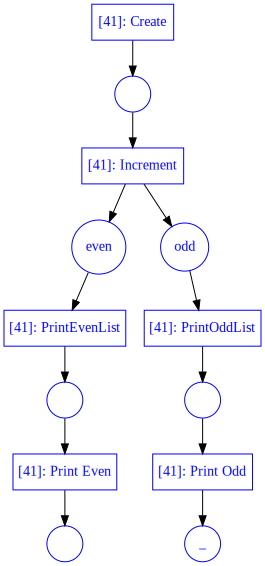

In [41]:
def compute(number):
  if number % 2 == 0:
      yield number
  else:
      yield pvalue.TaggedOutput("odd", number + 10)

with beam.Pipeline() as pipeline:
  even, odd = (pipeline
           | "Create" >> beam.Create([1, 2, 3, 4, 5, 6, 7])
           | "Increment" >> beam.ParDo(compute).with_outputs("odd", main="even"))
  
  # Print the PCollections
  _ = (even | 'PrintEvenList' >> beam.combiners.ToList()
    | 'Print Even' >> beam.Map(lambda x: passthrough('Evens:', x)))
  _ = (odd | 'PrintOddList' >> beam.combiners.ToList()
    | 'Print Odd' >> beam.Map(lambda x: passthrough('Odds:', x)))

display_pipeline(pipeline)

Note how the `Increment` stage returns two different `PCollections` in the graph above. **Untagged elements** will always be placed in the "main" `PCollection`.

Try tagging even elements and see what happens!

## [Branching](https://beam.apache.org/documentation/programming-guide/#applying-transforms)
A transform does not consume or otherwise alter the input collection – remember that a `PCollection` is immutable by definition. This means that you can apply multiple transforms to the same input `PCollection` to create a branching pipeline.

Let's create a pipeline with 3 branches, which produces 3 different `PCollections`.

Mult 5:: [5, 10, 15, 20, 25]
Numbers:: [1, 2, 3, 4, 5]
Mult 10:: [10, 20, 30, 40, 50]


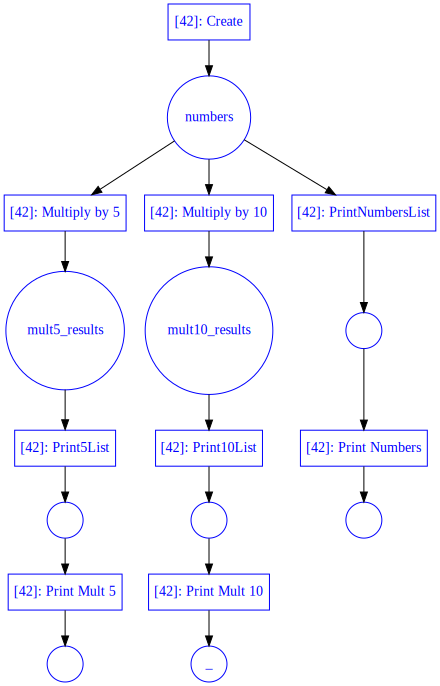

In [42]:
with beam.Pipeline() as branching_pipeline:
  numbers = (branching_pipeline | beam.Create([1, 2, 3, 4, 5]))
  mult5_results = numbers | 'Multiply by 5' >> beam.Map(lambda num: num * 5)
  mult10_results = numbers | 'Multiply by 10' >> beam.Map(lambda num: num * 10)

  # Print the PCollections
  _ = (numbers | 'PrintNumbersList' >> beam.combiners.ToList()
    | 'Print Numbers' >> beam.Map(lambda x: passthrough('Numbers:', x)))
  _ = (mult5_results | 'Print5List' >> beam.combiners.ToList()
    | 'Print Mult 5' >> beam.Map(lambda x: passthrough('Mult 5:', x)))
  _ = (mult10_results | 'Print10List' >> beam.combiners.ToList()
    | 'Print Mult 10' >> beam.Map(lambda x: passthrough('Mult 10:', x)))

display_pipeline(branching_pipeline)

## [Composite Transforms](https://beam.apache.org/documentation/programming-guide/#composite-transforms)
Transforms can have a nested structure, where a complex transform performs multiple simpler transforms (such as more than one `ParDo`, `Combine`, `GroupByKey`, or even other composite transforms). These transforms are called ***composite transforms***. Nesting multiple transforms inside a single composite transform can make your code more modular and easier to understand.

Your composite transform's parameters and return value must match the initial input type and final return type for the entire transform, even if the transform's intermediate data changes type multiple times.

To create a composite transform, create a subclass of the `PTransform` class and override the `expand` method to specify the actual processing logic. Then use this transform just as you would a built-in transform.

Numbers:: [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


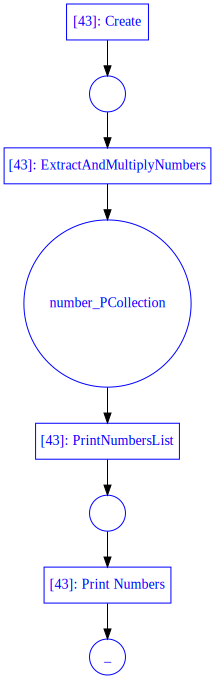

In [43]:
# Subclass beam.PTransform to create a composite transform
class ExtractAndMultiplyNumbers(beam.PTransform):
    def expand(self, pcollection):
        return (pcollection
            | beam.FlatMap(lambda line: line.split(","))
            | beam.Map(lambda num: int(num) * 10))

with beam.Pipeline() as composite_pipeline:
  number_PCollection = (composite_pipeline
           | beam.Create(['1,2,3,4,5', '6,7,8,9,10'])
           | ExtractAndMultiplyNumbers())
  
  # Print the PCollection
  _ = (number_PCollection | 'PrintNumbersList' >> beam.combiners.ToList()
    | 'Print Numbers' >> beam.Map(lambda x: passthrough('Numbers:', x)))

display_pipeline(composite_pipeline)

## [Filter](https://beam.apache.org/documentation/transforms/python/elementwise/filter/)
`Filter`, given a predicate, filters out all elements that don't satisfy that predicate. `Filter` may also be used to filter based on an inequality with a given value based on the comparison ordering of the element.  You can pass functions with multiple arguments to `Filter`. They are passed as additional positional arguments or keyword arguments to the function.  If the `PCollection` has a single value, such as the average from another computation, passing the `PCollection` as a *singleton* accesses that value.  If the `PCollection` has multiple values, pass the `PCollection` as an *iterator*. This accesses elements lazily as they are needed, so it is possible to iterate over large `PCollections` that won't fit into memory.

> Note: You can pass the `PCollection` as a list with `beam.pvalue.AsList(PCollection)`, but this requires that all the elements fit into memory.

> Note: You can pass the `PCollection` as a dictionary with `beam.pvalue.AsDict(PCollection)`. Each element must be a (key, value) pair. Note that all the elements of the `PCollection` must fit into memory.

If the `PCollection` won't fit into memory, use `beam.pvalue.AsIter(PCollection)` instead.

First, let's try filtering out even numbers using a `ParDo` transform.

In [46]:
class FilterOddNumbers(beam.DoFn):
    def process(self, element, *args, **kwargs):
        if element % 2 == 1:
            yield element

with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.ParDo(FilterOddNumbers())
           | beam.Map(lambda x: passthrough('Odd number:', x)))

Odd number: 1
Odd number: 3
Odd number: 5
Odd number: 7
Odd number: 9


Next, let's use `Filter` to do the same thing.

In [47]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.Filter(lambda num: num % 2 == 1)
           | beam.Map(lambda x: passthrough('Odd number:', x)))

Odd number: 1
Odd number: 3
Odd number: 5
Odd number: 7
Odd number: 9


## [Aggregation](https://beam.apache.org/documentation/programming-guide/)
Beam uses [windowing](https://urldefense.com/v3/__https://beam.apache.org/documentation/programming-guide/*windowing__;Iw!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxDyJyXgQ$ ) to divide a continuously updating unbounded `PCollection` into logical windows of finite size. These logical windows are determined by some characteristic associated with a data element, such as a timestamp. [Aggregation transforms](https://urldefense.com/v3/__https://beam.apache.org/documentation/transforms/python/overview/*aggregation__;Iw!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxGg6bt2E$ ) (such as GroupByKey and Combine) work on a per-window basis — as the data set is generated, they process each `PCollection` as a succession of these finite windows.

A related concept, called [triggers](https://urldefense.com/v3/__https://beam.apache.org/documentation/programming-guide/*triggers__;Iw!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxSPrnvUA$ ), determines when to emit the results of aggregation as unbounded data arrives. You can use triggers to refine the windowing strategy for your `PCollection`. Triggers allow you to deal with late-arriving data, or to provide early results.

First, let's count the elements in a `PCollection`.

In [48]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.combiners.Count.Globally() # Count
           | beam.Map(lambda x: passthrough('Count =', x)))

Count = 10


Next, let's sum the elements with a `CombineGlobally` aggregator and Python's sum.

In [49]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.CombineGlobally(sum) # CombineGlobally sum
           | beam.Map(lambda x: passthrough('Sum =', x)))

Sum = 55


Next, let's calculate the mean.

In [50]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.combiners.Mean.Globally() # Mean
           | beam.Map(lambda x: passthrough('Mean =', x)))

Mean = 5.5


Next, let's return the smallest element in the `PCollection`.

In [51]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.combiners.Top.Smallest(1) # Top Smallest
           | beam.Map(lambda x: passthrough('Smallest =', x)))

Smallest = [1]


Next, let's return the largest element in the `PCollection`.

In [52]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.Create(range(1, 11))
           | beam.combiners.Top.Largest(1) # Top Largest
           | beam.Map(lambda x: passthrough('Largest =', x)))

Largest = [10]


# [Pipeline I/O](https://beam.apache.org/documentation/programming-guide/#pipeline-io)
When you create a pipeline, you often need to read data from some external source, such as a file or a database. Likewise, you may want your pipeline to output its result data to an external storage system. Beam provides read and write transforms for a [number of common data storage types](https://beam.apache.org/documentation/io/built-in/). If you want your pipeline to read from or write to a data storage format that isn’t supported by the built-in transforms, you can [implement your own read and write transforms](https://beam.apache.org/documentation/io/developing-io-overview/) 
### Download example data
Download the sample dataset for use with the cells below.

In [53]:
import os, tempfile, urllib
DATA_PATH = 'https://raw.githubusercontent.com/tensorflow/tfx/master/tfx/examples/chicago_taxi_pipeline/data/simple/data.csv'
_data_root = tempfile.mkdtemp(prefix='tfx-data')
_data_filepath = os.path.join(_data_root, "data.csv")
urllib.request.urlretrieve(DATA_PATH, _data_filepath)

('/tmp/tfx-data3rbochd3/data.csv', <http.client.HTTPMessage at 0x7f4a22afd690>)

Let's take a quick look at the data.

In [54]:
!head {_data_filepath}

pickup_community_area,fare,trip_start_month,trip_start_hour,trip_start_day,trip_start_timestamp,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,trip_miles,pickup_census_tract,dropoff_census_tract,payment_type,company,trip_seconds,dropoff_community_area,tips
,12.45,5,19,6,1400269500,,,,,0.0,,,Credit Card,Chicago Elite Cab Corp. (Chicago Carriag,0,,0.0
,0,3,19,5,1362683700,,,,,0,,,Unknown,Chicago Elite Cab Corp.,300,,0
60,27.05,10,2,3,1380593700,41.836150155,-87.648787952,,,12.6,,,Cash,Taxi Affiliation Services,1380,,0.0
10,5.85,10,1,2,1382319000,41.985015101,-87.804532006,,,0.0,,,Cash,Taxi Affiliation Services,180,,0.0
14,16.65,5,7,5,1369897200,41.968069,-87.721559063,,,0.0,,,Cash,Dispatch Taxi Affiliation,1080,,0.0
13,16.45,11,12,3,1446554700,41.983636307,-87.723583185,,,6.9,,,Cash,,780,,0.0
16,32.05,12,1,1,1417916700,41.953582125,-87.72345239,,,15.4,,,Cash,,1200,,0.0
30,38.45,10,10,5,1444301100,41.839086906,-87.714003807,,,14.6,,,Cash,,2580,,0.0
11,14.65,1,1,3,1358

Let's filter out only the lines that we're interested in.

In [55]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.io.ReadFromText(_data_filepath)
           | beam.Filter(lambda line: line.startswith("13,16.45,11,12,3"))
           | beam.Map(lambda x: passthrough('Match:', x)))

Match: 13,16.45,11,12,3,1446554700,41.983636307,-87.723583185,,,6.9,,,Cash,,780,,0.0


### Putting Everything Together

Use several of the concepts, classes, and methods discussed above in a concrete example.

**Exercise 4 — Reading, Filtering, Parsing, Grouping and Averaging**

Write a Beam pipeline that reads the dataset, computes the mean fare for each company, and takes the top 5 companies with the largest mean fares.

*Hints*:
* Use the code above to read the dataset.
* Add a `Map` step to split each row on the commas.
* Filter out the header row and any rows without values for company.
* Calculate the mean fare for each company
* (Optional) Print the mean fares for each company
* Take the top 5 companies by mean fare
* Print the list of the top 5 companies

avg(Chicago Elite Cab Corp. (Chicago Carriag) = 14.194230769230769
avg(Chicago Elite Cab Corp.) = 11.972222222222221
avg(Taxi Affiliation Services) = 11.323531684698589
avg(Dispatch Taxi Affiliation) = 11.639559902200498
avg(Blue Ribbon Taxi Association Inc.) = 10.91353211009176
avg(Northwest Management LLC) = 11.596188747731384
avg(Choice Taxi Association) = 12.872488532110097
avg(Chicago Medallion Management) = 8.617647058823529
avg(Top Cab Affiliation) = 11.71439393939394
avg(KOAM Taxi Association) = 12.56158536585366
avg(5129 - Mengisti Taxi) = 7.8500000000000005
avg(6057 - 24657 Richard Addo) = 19.05
avg(3152 - 97284 Crystal Abernathy) = 9.183333333333332
avg(4615 - 83503 Tyrone Henderson) = 9.55
avg(3094 - 24059 G.L.B. Cab Co) = 5.05
avg(4615 - Tyrone Henderson) = 7.949999999999999
avg(2192 - 73487 Zeymane Corp) = 11.45
avg(3897 - 57856 Ilie Malec) = 5.05
avg(2823 - 73307 Seung Lee) = 34.05
avg(2733 - 74600 Benny Jona) = 16.116666666666664
avg(3253 - 91138 Gaither Cab Co.) = 13.0

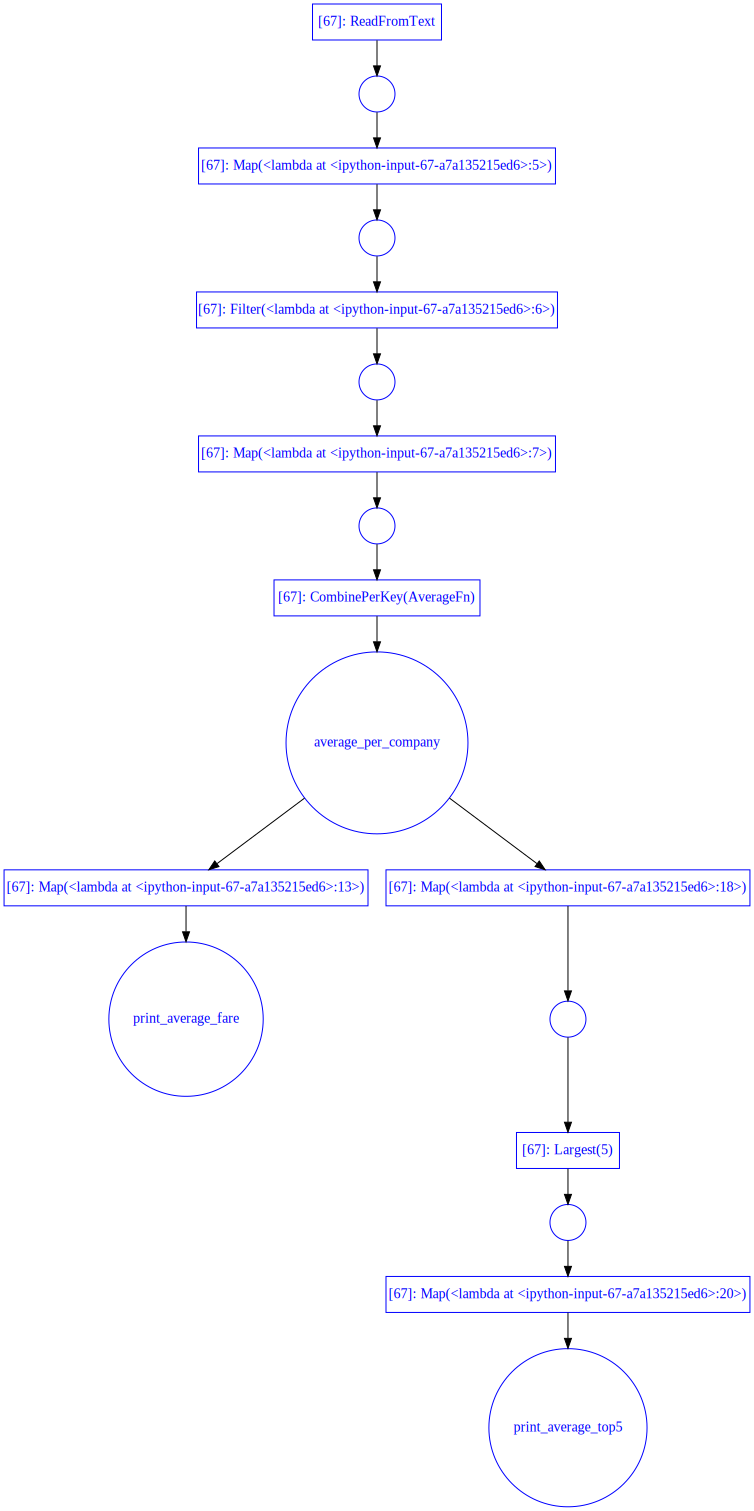

In [67]:
with beam.Pipeline() as pipeline:
    average_per_company = (
        pipeline
        | beam.io.ReadFromText(_data_filepath)
        | beam.Map(lambda x: x.split(','))
        | beam.Filter(lambda x: x[0] != 'pickup_community_area' and x[-4])
        | beam.Map(lambda x: (x[-4], float(x[1])))
        | beam.CombinePerKey(AverageFn())
    )
    
    print_average_fare = (
        average_per_company
        | beam.Map(lambda x: passthrough('avg({}) ='.format(x[0]), x[1]))
    )
    
    print_average_top5 = (
        average_per_company
        | beam.Map(lambda x: (x[1], x[0]))
        | beam.combiners.Top.Largest(5)
        | beam.Map(lambda x: passthrough('Top 5 Companies =', x))
    )
    
display_pipeline(pipeline)

![Solution](https://urldefense.com/v3/__https://www.tensorflow.org/site-assets/images/marketing/learn/tfx-hero.svg__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxzvhZF7w$ )

**Solution**:

In [66]:
with beam.Pipeline() as pipeline:
  lines = (pipeline
           | beam.io.ReadFromText(_data_filepath)
           | beam.Map(lambda line: line.split(",")) # CSV
           | beam.Filter(lambda cols: len(cols[-4]) > 0 and cols[0] != 'pickup_community_area')
           | beam.Map(lambda cols: (cols[-4], float(cols[1]))) # (Company, Mean Fare) for PerKey
           | beam.combiners.Mean.PerKey() # Mean fare by company
           | beam.Map(lambda cols: (cols[1], cols[0])) # Switch to (Mean Fare, Company) for Top
           | beam.Map(lambda x: passthrough('(Mean Fare, Company):', x))
           | beam.combiners.Top.Largest(5) # Top 5 mean fares
           | beam.Map(lambda x: passthrough('Top 5:', x)))

(Mean Fare, Company): (14.194230769230769, 'Chicago Elite Cab Corp. (Chicago Carriag')
(Mean Fare, Company): (11.972222222222221, 'Chicago Elite Cab Corp.')
(Mean Fare, Company): (11.323531684698589, 'Taxi Affiliation Services')
(Mean Fare, Company): (11.639559902200498, 'Dispatch Taxi Affiliation')
(Mean Fare, Company): (10.91353211009176, 'Blue Ribbon Taxi Association Inc.')
(Mean Fare, Company): (11.596188747731384, 'Northwest Management LLC')
(Mean Fare, Company): (12.872488532110097, 'Choice Taxi Association')
(Mean Fare, Company): (8.617647058823529, 'Chicago Medallion Management')
(Mean Fare, Company): (11.71439393939394, 'Top Cab Affiliation')
(Mean Fare, Company): (12.56158536585366, 'KOAM Taxi Association')
(Mean Fare, Company): (7.8500000000000005, '5129 - Mengisti Taxi')
(Mean Fare, Company): (19.05, '6057 - 24657 Richard Addo')
(Mean Fare, Company): (9.183333333333332, '3152 - 97284 Crystal Abernathy')
(Mean Fare, Company): (9.55, '4615 - 83503 Tyrone Henderson')
(Mean Far

## Beam I/O and TFX

Since TensorFlow and TFX often use the [TFRecord](https://urldefense.com/v3/__https://www.tensorflow.org/tutorials/load_data/tfrecord__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxBE9fjf0$ ) format, let's use Beam I/O with TFRecord files.  

First, let's create a test file containing 10 records of "Record X" strings in UTF-8.

In [56]:
#!pip install -q -U "tensorflow>=2.1,<=2.2"

import tensorflow as tf
with tf.io.TFRecordWriter("test.tfrecord") as tfrecord_file:
  for index in range(10):
    tfrecord_file.write("Record {}".format(index).encode("utf-8"))

dataset = tf.data.TFRecordDataset('test.tfrecord')
for record in dataset:
  print(record.numpy().decode('utf-8'))

Record 0
Record 1
Record 2
Record 3
Record 4
Record 5
Record 6
Record 7
Record 8
Record 9


Now let's read the test file and process each of the records.  We'll write the results to a second `TFRecord` file, one record for each record processed.

test_processed.tfrecord-00000-of-00001


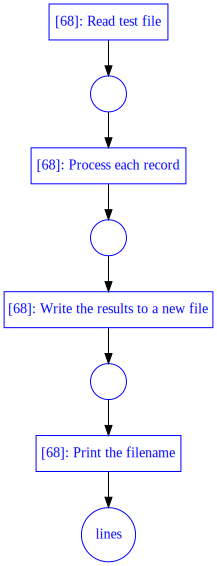

In [68]:
with beam.Pipeline() as rw_pipeline:
  lines = (rw_pipeline
           | 'Read test file' >> beam.io.ReadFromTFRecord("test.tfrecord")
           | 'Process each record' >> beam.Map(lambda line: line + b' processed')
           | 'Write the results to a new file' >> beam.io.WriteToTFRecord("test_processed.tfrecord")
           | 'Print the filename' >> beam.ParDo(print))

display_pipeline(rw_pipeline)

Now let's read the results file and print each record.

Record 0 processed
Record 1 processed
Record 2 processed
Record 3 processed
Record 4 processed
Record 5 processed
Record 6 processed
Record 7 processed
Record 8 processed
Record 9 processed


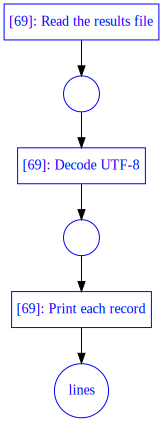

In [69]:
with beam.Pipeline() as utf_pipeline:
  lines = (utf_pipeline
           | "Read the results file" >> beam.io.ReadFromTFRecord("test_processed.tfrecord-00000-of-00001")
           | "Decode UTF-8" >> beam.Map(lambda line: line.decode('utf-8'))
           | "Print each record" >> beam.ParDo(print))

display_pipeline(utf_pipeline)

Note that there are many [other built-in I/O transforms](https://urldefense.com/v3/__https://beam.apache.org/documentation/io/built-in/__;!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxE3x8M-c$ ).

# [Windowing](https://beam.apache.org/documentation/programming-guide/#windowing)
As discussed above, windowing subdivides a `PCollection` according to the timestamps, or some other ordering or grouping, of its individual elements.

Some Beam transforms, such as `GroupByKey` and `Combine`, group multiple elements by a common key. Ordinarily, that grouping operation groups all of the elements that have the same key within the entire data set. With an unbounded data set, it is impossible to collect all of the elements, since new elements are constantly being added and may be infinitely many (e.g. streaming data). If you are working with unbounded `PCollections`, windowing is especially useful.

In the Beam model, any `PCollection` (including unbounded `PCollections`) can be subdivided into logical windows. Each element in a `PCollection` is assigned to one or more windows according to the `PCollection`'s windowing function, and each individual window contains a finite number of elements. Grouping transforms then consider each `PCollection`'s elements on a per-window basis. `GroupByKey`, for example, implicitly groups the elements of a `PCollection` by key and window.

Additional information on Beam Windowing is available in the [Beam Programming Guide](https://urldefense.com/v3/__https://beam.apache.org/documentation/programming-guide/*windowing__;Iw!!PIZeeW5wscynRQ!55X7LkP-oqeRJ6UUmtPVv4vn3HLBOqlFNpBPTKq9j6A_FsUVIeCO-4RxDyJyXgQ$ ).

Let's begin by creating a pipeline to:

* Read our CSV file above
* Create fixed windows for each week
* Calculate the mean fare by company for each week
* Group the companies by week
* Print out 2016 only

(Window end, [Mean fares by company]): ('2016-04-21 00:00:00', [('Taxi Affiliation Services', 13.6875), ('Dispatch Taxi Affiliation', 9.5), ('Choice Taxi Association', 7.0)])
(Window end, [Mean fares by company]): ('2016-06-09 00:00:00', [('Taxi Affiliation Services', 23.15), ('Dispatch Taxi Affiliation', 13.75), ('Blue Ribbon Taxi Association Inc.', 7.75), ('Choice Taxi Association', 22.375)])
(Window end, [Mean fares by company]): ('2016-08-25 00:00:00', [('Taxi Affiliation Services', 36.75), ('Dispatch Taxi Affiliation', 6.75), ('Blue Ribbon Taxi Association Inc.', 10.5), ('Choice Taxi Association', 6.0)])
(Window end, [Mean fares by company]): ('2016-12-08 00:00:00', [('Taxi Affiliation Services', 14.15), ('Dispatch Taxi Affiliation', 12.25), ('Blue Ribbon Taxi Association Inc.', 22.25), ('Northwest Management LLC', 4.0), ('Choice Taxi Association', 6.625)])
(Window end, [Mean fares by company]): ('2016-05-12 00:00:00', [('Taxi Affiliation Services', 7.666666666666667), ('Dispatch 

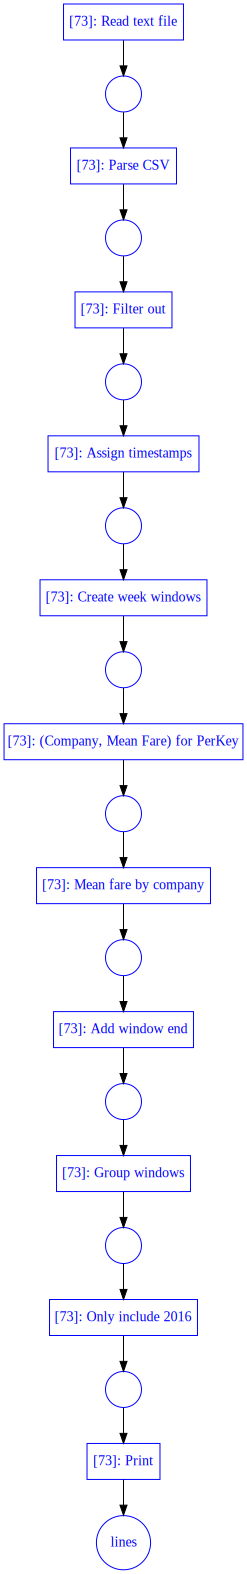

In [73]:
import datetime

DAYS = 24 * 60 * 60

class BuildRecordFn(beam.DoFn):
  def process(self, element,  window=beam.DoFn.WindowParam):
      window_end = str(window.end.to_utc_datetime())
      return [(window_end, element)]

class AssignTimestamps(beam.DoFn):
  def process(self, element):
    ts = int(element[5])
    yield beam.window.TimestampedValue(element, ts)

with beam.Pipeline() as window_pipeline:
  lines = (window_pipeline
           | 'Read text file' >> beam.io.ReadFromText(_data_filepath)
           | 'Parse CSV' >> beam.Map(lambda line: line.split(","))
           | 'Filter out' >> beam.Filter(lambda cols: len(cols[-4]) > 0 and cols[0] != 'pickup_community_area')
           | 'Assign timestamps' >> beam.ParDo(AssignTimestamps())
           | 'Create week windows' >> beam.WindowInto(beam.window.FixedWindows(7*DAYS))
           | '(Company, Mean Fare) for PerKey' >> beam.Map(lambda cols: (cols[-4], float(cols[1])))
           | 'Mean fare by company' >> beam.combiners.Mean.PerKey()
           | 'Add window end' >> beam.ParDo(BuildRecordFn())
           | 'Group windows' >> beam.GroupByKey()
           | 'Only include 2016' >> beam.Filter(lambda win: win[0] > '2016' and win[0] < '2017')
#           | 'Sort by Key' >> beam.SortByKey()
           | 'Print' >> beam.Map(lambda x: passthrough('(Window end, [Mean fares by company]):', x)))

display_pipeline(window_pipeline)